# Capítulo 6. Algoritmos y Fundamentos Probabilísticos con Python 

### 7.2 Fundamentos Probabilísticos en Econometría 

En econometría, utilizamos modelos para analizar datos económicos como regresiones lineales o modelos de series temporales, estos se basan en supuestos probabilísticos sobre las variables y sus errores. Comprender y validar estas distribuciones es crucial para garantizar que los resultados de nuestros modelos sean confiables y no estén sesgados. 

Algunas de las distribuciones estadísticas más comunes incluyen:  

    - Normal: Utilizada para modelar errores de regresión o variables como ingresos en poblaciones grandes.  
    - Log-Normal:  
    - t de Student: Usada en muestras pequeñas o cuando los datos tienen colas más pesadas que la normal. 
    - Poisson: Aplicable a variables de conteo, como el número de transacciones en un mercado. 

##### __Algoritmo 1: Estimación de Parámetros de una Distribución Normal__

In [9]:
import numpy as np 
from scipy import stats 
import matplotlib.pyplot as plt 

# Generar datos ficticios: Ingresos mensuales de hogares (en miles de dólares)
np.random.seed(42)  # Para reproducibilidad
ingresos = np.random.normal(loc=3.5, scale=0.8, size=1000)  # Media=3.5, desviación estándar=0.8, 100 observaciones
ingresos = np.round(ingresos, 2)  # Redondear a 2 decimales para realismo

# Estimar parámetros de la distribución normal 
mu, sigma = stats.norm.fit(ingresos) 

# Imprimir resultados 
print(f"Media estimada: {mu:.2f} mil dólares") 
print(f"Desviación estándar estimada: {sigma:.2f} mil dólares")  

Media estimada: 3.52 mil dólares
Desviación estándar estimada: 0.78 mil dólares


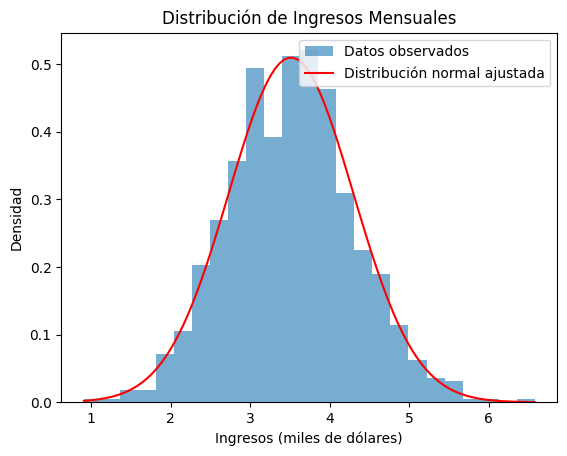

In [15]:
import matplotlib.pyplot as plt 

# Visualizar la distribución 
x = np.linspace(min(ingresos), max(ingresos), 100) 
pdf = stats.norm.pdf(x, mu, sigma) 

plt.hist(ingresos, bins=25, density=True, alpha=0.6, label="Datos observados") 
plt.plot(x, pdf, 'r-', label="Distribución normal ajustada") 
plt.title("Distribución de Ingresos Mensuales") 
plt.xlabel("Ingresos (miles de dólares)") 
plt.ylabel("Densidad") 
plt.legend() 
plt.show()

##### __Algoritmo 2: Prueba de Bondad de Ajuste (Kolmogorov-Smirnov)__

Para validar si los datos económicos se ajustan a una distribución teórica, como la normal, podemos usar pruebas de bondad de ajuste. La prueba de Kolmogorov-Smirnov (KS) compara la distribución empírica de los datos con una distribución teórica, ayudando a verificar supuestos econométricos. 

In [21]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Generar datos de ejemplo: Residuos de una regresión (simulados como normales)
np.random.seed(42)  # Para reproducibilidad
residuos = np.random.normal(loc=0, scale=1, size=1000)  # Media=0, desviación estándar=1, 100 observaciones

# Prueba de Kolmogorov-Smirnov contra una distribución normal
ks_stat, p_value = stats.kstest(residuos, 'norm', args=(np.mean(residuos), np.std(residuos)))

# Imprimir resultados
print("Prueba de Kolmogorov-Smirnov para normalidad de residuos:")
print(f"Estadístico KS: {ks_stat:.4f}")
print(f"Valor p: {p_value:.4f}")

if p_value > 0.05:
    print("No se rechaza la hipótesis nula: los residuos son consistentes con una distribución normal.")
else:
    print("Se rechaza la hipótesis nula: los residuos no siguen una distribución normal.")


Prueba de Kolmogorov-Smirnov para normalidad de residuos:
Estadístico KS: 0.0215
Valor p: 0.7370
No se rechaza la hipótesis nula: los residuos son consistentes con una distribución normal.


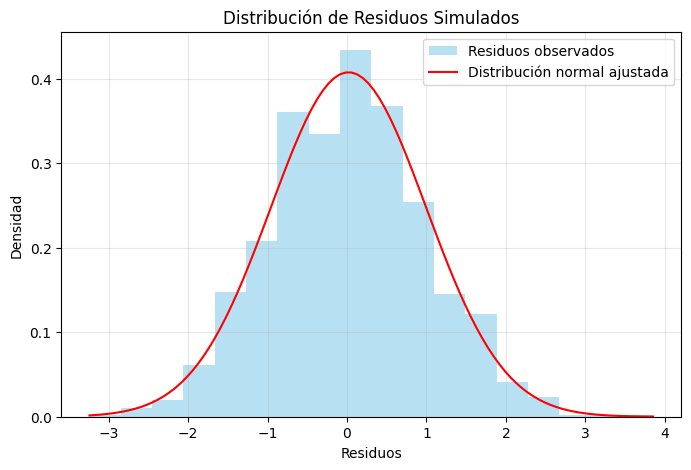

In [22]:
import matplotlib.pyplot as plt 

# Visualizar la distribución de los residuos
plt.figure(figsize=(8, 5))
plt.hist(residuos, bins=18, density=True, alpha=0.6, color='skyblue', label="Residuos observados")
x = np.linspace(min(residuos), max(residuos), 100)
pdf = stats.norm.pdf(x, np.mean(residuos), np.std(residuos))
plt.plot(x, pdf, 'r-', label="Distribución normal ajustada")
plt.title("Distribución de Residuos Simulados")
plt.xlabel("Residuos")
plt.ylabel("Densidad")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 7.3 Algoritmos de regresión para análisis económico  

A continuación, exploraremos dos algoritmos de regresión fundamentales: la regresión lineal ordinaria (OLS), para variables continuas, y la regresión logística, para variables categóricas. Ambos se implementan en Python usando la librería “statsmodels”, y combinan métodos computacionales con los fundamentos probabilísticos discutidos en la sección anterior.  

##### __Algoritmo 1: Regresión Lineal Ordinaria (OLS)__

In [27]:
#!pip install statsmodels

In [30]:
import pandas as pd  
import statsmodels.api as sm  
import matplotlib.pyplot as plt  
from scipy import stats 

# Datos de ejemplo: PIB per cápita (miles de dólares) vs. Inversión (millones de dólares) 
data = pd.DataFrame({ 
    'PIB_per_capita': [
        20.2, 25.1, 30.0, 28.4, 32.3, 22.5, 27.8, 31.2, 29.0, 33.5,
        21.7, 26.4, 30.8, 27.9, 34.1, 23.3, 28.6, 32.7, 26.5, 31.9,
        24.8, 29.2, 33.4, 25.7, 30.5, 22.9, 27.3, 31.8, 28.2, 32.6,
        20.9, 26.1, 30.4, 28.7, 33.2, 23.6, 28.0, 32.3, 27.1, 31.4,
        25.0, 29.5, 34.0, 26.3, 30.7, 22.4, 27.6, 32.1, 28.9, 33.8
    ], 
    'Inversion': [
        1000, 1500, 2000, 1800, 2200, 1100, 1600, 2100, 1700, 2300,
        1200, 1550, 2050, 1750, 2250, 1150, 1650, 2150, 1450, 1950,
        1300, 1850, 2350, 1400, 1900, 1050, 1500, 2000, 1700, 2200,
        950, 1450, 1950, 1750, 2150, 1250, 1600, 2100, 1350, 1850,
        1400, 1900, 2400, 1300, 1800, 1000, 1550, 2050, 1650, 2250
    ]
})

# Definir variables 
X = data['Inversion']  
y = data['PIB_per_capita']  
X = sm.add_constant(X) # Agregar intercepto 

# Ajustar modelo OLS 
model = sm.OLS(y, X).fit() 
print(model.summary()) 

                            OLS Regression Results                            
Dep. Variable:         PIB_per_capita   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     856.7
Date:                Fri, 23 May 2025   Prob (F-statistic):           2.91e-32
Time:                        18:02:19   Log-Likelihood:                -63.346
No. Observations:                  50   AIC:                             130.7
Df Residuals:                      48   BIC:                             134.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.7302      0.551     23.101      0.0

In [31]:
# Verificar supuesto de normalidad de los errores 
residuos = model.resid  
ks_stat, p_value = stats.kstest(residuos, 'norm', args=(residuos.mean(), residuos.std())) 

print(f"\nPrueba KS para normalidad de residuos:")  
print(f"Estadístico KS: {ks_stat:.4f}, Valor p: {p_value:.4f}")  

if p_value > 0.05:  
    print("No se rechaza la hipótesis nula: los residuos son consistentes con una distribución normal.")  
else:  
    print("Se rechaza la hipótesis nula: los residuos no siguen una distribución normal.")  


Prueba KS para normalidad de residuos:
Estadístico KS: 0.0779, Valor p: 0.8989
No se rechaza la hipótesis nula: los residuos son consistentes con una distribución normal.


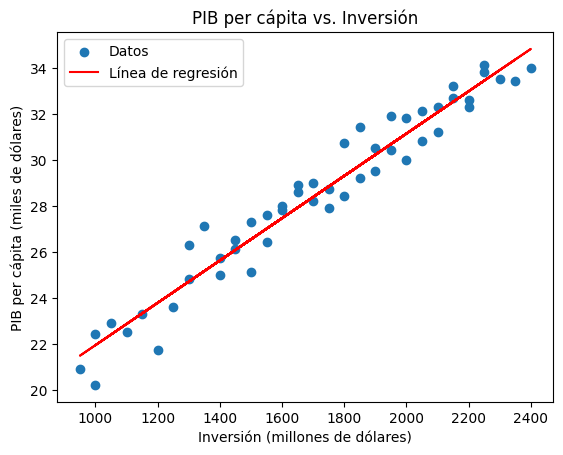

In [33]:
# Visualizar la regresión 

plt.scatter(data['Inversion'], data['PIB_per_capita'], label="Datos") 
plt.plot(data['Inversion'], model.predict(X), color='red', label="Línea de regresión") 
plt.title("PIB per cápita vs. Inversión") 
plt.xlabel("Inversión (millones de dólares)") 
plt.ylabel("PIB per cápita (miles de dólares)") 
plt.legend() 
plt.show() 

##### __Algoritmo 2: Regresión Logística__

La regresión logística se utiliza cuando la variable dependiente es categórica, típicamente binaria (por ejemplo, 0 o 1). En economía, es útil para modelar decisiones, como si un consumidor compra un producto (1) o no (0), en función de variables como el ingreso. 

In [36]:
import pandas as pd  
import statsmodels.api as sm  
import matplotlib.pyplot as plt  
import numpy as np 

# Generar datos ficticios: Compra (1=sí, 0=no) vs. Ingreso (miles de dólares)
np.random.seed(42)  # Para reproducibilidad

n = 50  # Número de observaciones
ingreso = np.random.uniform(15, 50, n)  # Ingresos entre 15 y 50 mil dólares
# Generar probabilidades logísticas basadas en el ingreso
log_odds = -5 + 0.15 * ingreso  # Relación logística: log-odds = -5 + 0.15 * Ingreso
probs = 1 / (1 + np.exp(-log_odds))  # Probabilidad de Compra=1
compra = np.random.binomial(1, probs)  # Generar Compra (0 o 1) con probabilidad probs

# Crear DataFrame
data = pd.DataFrame({ 
    'Compra': compra,
    'Ingreso': np.round(ingreso, 2)  # Redondear ingresos a 2 decimales
})

# Definir variables  
X = data['Ingreso']  
y = data['Compra']  
X = sm.add_constant(X) 

# Ajustar modelo logístico  
model = sm.Logit(y, X).fit() 

# Imprimir resultados  
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.450920
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 Compra   No. Observations:                   50
Model:                          Logit   Df Residuals:                       48
Method:                           MLE   Df Model:                            1
Date:                Fri, 23 May 2025   Pseudo R-squ.:                  0.3300
Time:                        18:07:23   Log-Likelihood:                -22.546
converged:                       True   LL-Null:                       -33.651
Covariance Type:            nonrobust   LLR p-value:                 2.445e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.8970      1.573     -3.749      0.000      -8.980      -2.814
Ingreso        0.1733      0.

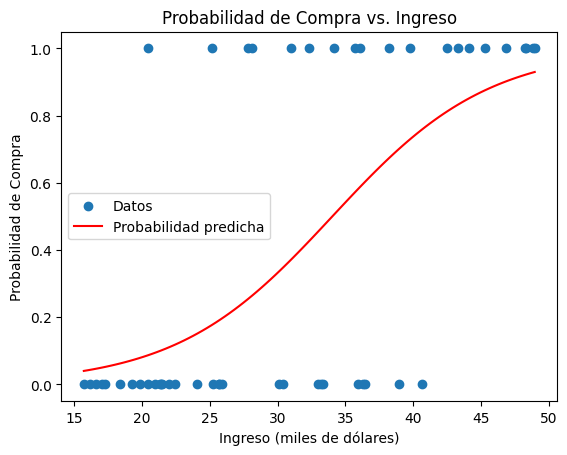

In [41]:
# Visualizar la probabilidad  
x_range = np.linspace(min(data['Ingreso']), max(data['Ingreso']), 100)  
X_range = sm.add_constant(x_range)  
probs = model.predict(X_range)

# hacer el plot  
plt.scatter(data['Ingreso'], data['Compra'], label="Datos")  
plt.plot(x_range, probs, color='red', label="Probabilidad predicha")  
plt.title("Probabilidad de Compra vs. Ingreso")  
plt.xlabel("Ingreso (miles de dólares)")  
plt.ylabel("Probabilidad de Compra")  
plt.legend() 
plt.show() 

### 7.4 Modelos de Series Temporales 

Las series temporales son datos recopilados en intervalos de tiempo regulares, como el PIB trimestral, la inflación mensual o los precios diarios de acciones. En econometría, los modelos de series temporales permiten analizar patrones, tendencias y ciclos en estos datos, así como realizar predicciones sobre su comportamiento futuro. Estos modelos se basan en fundamentos probabilísticos, como la estacionariedad (propiedades estadísticas constantes en el tiempo) y la distribución de los errores, que son esenciales para garantizar estimaciones confiables.  


In [50]:
import pandas as pd  
import statsmodels.api as sm  
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.stattools import adfuller  
import matplotlib.pyplot as plt  
from scipy import stats 

# Generar datos ficticios: Inflación mensual (%) para 50 meses
np.random.seed(42)  # Para reproducibilidad
n = 50  # Número de observaciones
dates = pd.date_range('2020-01-31', periods=n, freq='ME')
# Generar inflación con una tendencia suave y ruido
trend = 0.02 * np.arange(n)  # Tendencia leve (0.02% por mes)
ruido = np.random.normal(0, 0.3, n)  # Ruido normal con desv. estándar 0.3
inflacion = 2.0 + trend + ruido  # Inflación base de 2.0%
inflacion = np.round(inflacion, 2)  # Redondear a 2 decimales

# Crear Serie
data = pd.Series(inflacion, index=dates)

# Verificar estacionariedad con la prueba de Dickey-Fuller aumentada 
result = adfuller(data)  
print(f"Estadístico ADF: {result[0]:.4f}, Valor p: {result[1]:.4f}")  

if result[1] > 0.05:  
    print("No se rechaza la hipótesis nula: la serie no es estacionaria.")  
else:  
    print("Se rechaza la hipótesis nula: la serie es estacionaria.") 

# Ajustar modelo ARIMA(1,1,1) 
model = ARIMA(data, order=(1, 1, 1)).fit() 

# Imprimir resultados 
print(model.summary())

Estadístico ADF: -0.7841, Valor p: 0.8237
No se rechaza la hipótesis nula: la serie no es estacionaria.
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   50
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -10.804
Date:                Fri, 23 May 2025   AIC                             27.607
Time:                        18:17:10   BIC                             33.283
Sample:                    01-31-2020   HQIC                            29.761
                         - 02-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0254      0.247     -0.103      0.918      -0.509       0.458
ma.L1         -0.7795      

In [51]:
# Verificar normalidad de los residuos 
residuos = model.resid 

ks_stat, p_value = stats.kstest(residuos, 'norm', args=(residuos.mean(), residuos.std()))  
print(f"\nPrueba KS para normalidad de residuos:")  
print(f"Estadístico KS: {ks_stat:.4f}, Valor p: {p_value:.4f}")  

if p_value > 0.05:  
    print("No se rechaza la hipótesis nula: los residuos son consistentes con una distribución normal.")  
else:  
    print("Se rechaza la hipótesis nula: los residuos no siguen una distribución normal.") 

# Predecir los próximos 3 meses 
forecast = model.forecast(steps=3)  
print(f"\nPronósticos para los próximos 3 meses:\n{forecast}") 


Prueba KS para normalidad de residuos:
Estadístico KS: 0.1313, Valor p: 0.3261
No se rechaza la hipótesis nula: los residuos son consistentes con una distribución normal.

Pronósticos para los próximos 3 meses:
2024-03-31    2.791009
2024-04-30    2.782349
2024-05-31    2.782569
Freq: ME, Name: predicted_mean, dtype: float64


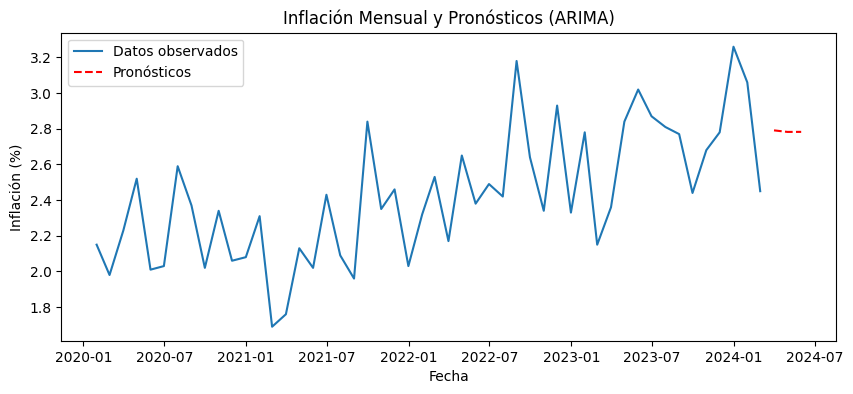

In [56]:
#Visualizar datos y predicciones 

plt.figure(figsize=(10, 4))
plt.plot(data, label="Datos observados")  
plt.plot(forecast.index, forecast, 'r--', label="Pronósticos")  
plt.title("Inflación Mensual y Pronósticos (ARIMA)")  
plt.xlabel("Fecha")  
plt.ylabel("Inflación (%)")  
plt.legend() 
plt.show() 

### 7. 5 Simulaciones y Análisis de Riesgo  

En economía, la incertidumbre es una característica inherente de fenómenos como los retornos financieros, los precios de mercado o los efectos de políticas económicas. Los algoritmos de simulación, como el método de Monte Carlo, permiten modelar esta incertidumbre generando escenarios aleatorios basados en distribuciones estadísticas, como la normal o log-normal, que son fundamentales en econometría. Estas simulaciones nos ayudan a estimar riesgos, evaluar resultados probables y tomar decisiones informadas. 

#### __Simulación de Monte Carlo para el Valor en Riesgo (VaR)__

In [62]:
import numpy as np  
import matplotlib.pyplot as plt  
from scipy import stats 

# Parámetros de la simulación 
mu = 0.05 # Retorno esperado anual  
sigma = 0.2 # Volatilidad anual  
n_simulaciones = 10_000 # Número de simulaciones  
n_dias = 252 # Días hábiles en un año  
inversion_inicial = 1000 # Inversión inicial en dólares 

# Simular retornos diarios con una distribución log-normal 
np.random.seed(42) # Para reproducibilidad  

retornos_diarios = np.random.lognormal(mean=mu/n_dias, sigma=sigma/np.sqrt(n_dias), size=(n_simulaciones, n_dias)) 

# Calcular valores finales de la cartera 
valores_finales = inversion_inicial * np.exp(np.sum(np.log(retornos_diarios), axis=1)) 

# Calcular VaR al 5% 
VaR_5 = np.percentile(valores_finales - inversion_inicial, 5)  

print(f"Valor en Riesgo (VaR) al 5%: ${-VaR_5:.2f}") 

Valor en Riesgo (VaR) al 5%: $247.08


In [63]:
# Verificar la distribución de los retornos simulados 

retornos_totales = np.sum(np.log(retornos_diarios), axis=1)  
ks_stat, p_value = stats.kstest(retornos_totales, 'norm', args=(retornos_totales.mean(), retornos_totales.std()))  

print(f"\nPrueba KS para normalidad de retornos totales:")  
print(f"Estadístico KS: {ks_stat:.4f}, Valor p: {p_value:.4f}")  

if p_value > 0.05:  
     print("No se rechaza la hipótesis nula: los retornos totales son consistentes con una distribución normal.")  
else:  
    print("Se rechaza la hipótesis nula: los retornos totales no siguen una distribución normal.") 


Prueba KS para normalidad de retornos totales:
Estadístico KS: 0.0092, Valor p: 0.3657
No se rechaza la hipótesis nula: los retornos totales son consistentes con una distribución normal.


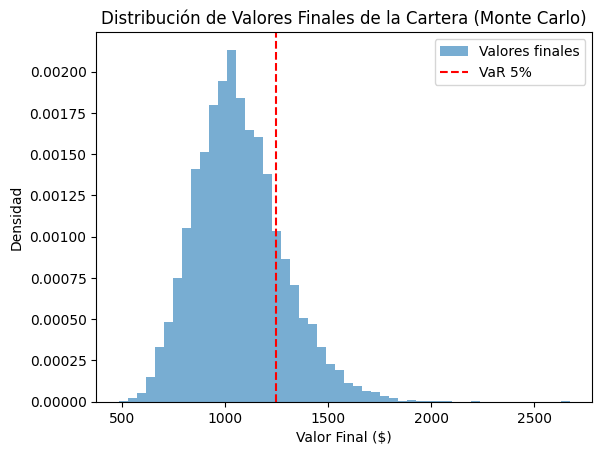

In [64]:
# Visualizar la distribución de valores finales 

plt.hist(valores_finales, bins=50, density=True, alpha=0.6, label="Valores finales") 
plt.axvline(inversion_inicial - VaR_5, color='red', linestyle='--', label='VaR 5%') 
plt.title("Distribución de Valores Finales de la Cartera (Monte Carlo)")  
plt.xlabel("Valor Final ($)") 
plt.ylabel("Densidad")  
plt.legend()  
plt.show() 

### 7. 6 Validación de Supuestos Probabilísticos 

##### Algoritmo 1: Prueba de Normalidad de los Residuos (Shapiro-Wilk) 

In [71]:
import pandas as pd  
import statsmodels.api as sm  
from scipy import stats  
import matplotlib.pyplot as plt 


# Generar datos ficticios: PIB per cápita (miles de dólares) vs. Inversión (millones de dólares)
np.random.seed(42)  # Para reproducibilidad
n = 500  # Número de observaciones
inversion = np.random.uniform(500, 3000, n)  # Inversión entre 500 y 3000 millones
error = np.random.normal(0, 2, n)  # Errores normales con desv. estándar 2
pib_per_capita = 10 + 0.01 * inversion + error  # Relación lineal con ruido
pib_per_capita = np.round(pib_per_capita, 2)  # Redondear a 2 decimales

# Crear DataFrame
data = pd.DataFrame({'PIB_per_capita': pib_per_capita, 'Inversion': inversion})

# Ajustar modelo OLS  
X = data['Inversion']  
y = data['PIB_per_capita']  
X = sm.add_constant(X)  

model = sm.OLS(y, X).fit() 

# Obtener residuos 
residuos = model.resid 

# Prueba de Shapiro-Wilk para normalidad  
shapiro_stat, p_value = stats.shapiro(residuos)  

print(f"Prueba de Shapiro-Wilk para normalidad de residuos:")  
print(f"Estadístico: {shapiro_stat:.4f}, Valor p: {p_value:.4f}") 

if p_value > 0.05:  
    print("No se rechaza la hipótesis nula: los residuos son consistentes con una distribución normal.")  
else:  
    print("Se rechaza la hipótesis nula: los residuos no siguen una distribución normal.") 

Prueba de Shapiro-Wilk para normalidad de residuos:
Estadístico: 0.9968, Valor p: 0.4421
No se rechaza la hipótesis nula: los residuos son consistentes con una distribución normal.


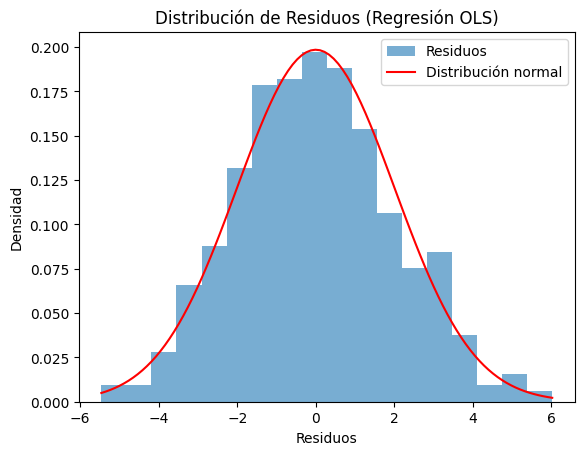

In [72]:
# Visualizar distribución de los residuos  

plt.hist(residuos, bins=18, density=True, alpha=0.6, label="Residuos")  
x = np.linspace(min(residuos), max(residuos), 100)  
plt.plot(x, stats.norm.pdf(x, residuos.mean(), residuos.std()), 'r-', label="Distribución normal")  
plt.title("Distribución de Residuos (Regresión OLS)")  
plt.xlabel("Residuos")  
plt.ylabel("Densidad")  
plt.legend()  
plt.show() 

#### Algoritmo 2: Prueba de Homoscedasticidad (Breusch-Pagan) 

In [73]:
import statsmodels.stats.diagnostic as smd 

bp_test = smd.het_breuschpagan(model.resid, model.model.exog)  
labels = ['Estadístico LM', 'Valor p LM', 'Estadístico F', 'Valor p F']  

print(f"Prueba de Breusch-Pagan para homoscedasticidad:")  

for label, value in zip(labels, bp_test):   
    print(f"{label}: {value:.4f}")  
    if bp_test[1] > 0.05:  
        print("No se rechaza la hipótesis nula: los residuos son homoscedásticos.")  
    else:  
        print("Se rechaza la hipótesis nula: los residuos son heteroscedásticos.") 


Prueba de Breusch-Pagan para homoscedasticidad:
Estadístico LM: 1.1485
No se rechaza la hipótesis nula: los residuos son homoscedásticos.
Valor p LM: 0.2839
No se rechaza la hipótesis nula: los residuos son homoscedásticos.
Estadístico F: 1.1465
No se rechaza la hipótesis nula: los residuos son homoscedásticos.
Valor p F: 0.2848
No se rechaza la hipótesis nula: los residuos son homoscedásticos.


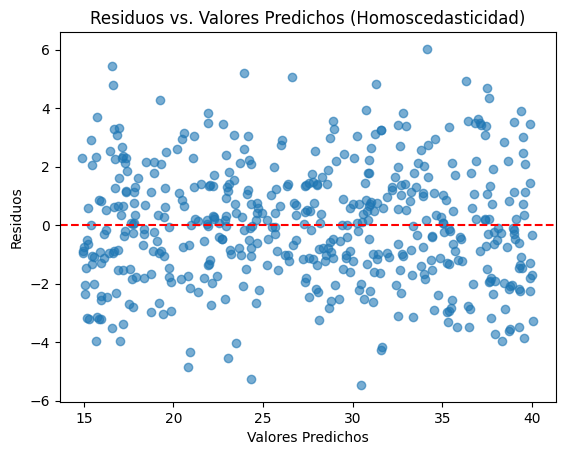

In [74]:

plt.scatter(model.fittedvalues, model.resid, alpha=0.6) 
plt.axhline(0, color='red', linestyle='--') 
plt.title("Residuos vs. Valores Predichos (Homoscedasticidad)") 
plt.xlabel("Valores Predichos")  
plt.ylabel("Residuos")  
plt.show() 

#### Algoritmo 3: Prueba de Ausencia de Autocorrelación (gráfico de autocorrelación) 

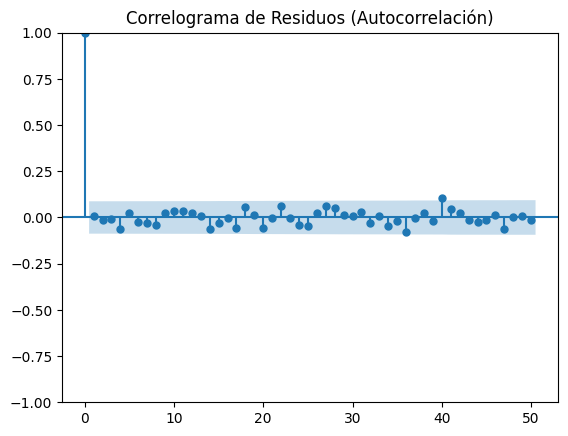

In [79]:
from statsmodels.graphics.tsaplots import plot_acf 

# Usar los residuos del modelo OLS anterior 
# Graficar correlograma 
plot_acf(residuos, lags=50, alpha=0.05) 
plt.title("Correlograma de Residuos (Autocorrelación)") 
plt.show() 

### 7. 7 Aplicaciones Prácticas en Economía 

#### Caso práctico: Impacto de las patentes en el PIB per cápita 

  

Supongamos que tenemos datos anuales de un país para los años 2015-2024, con el PIB per cápita (en miles de dólares) y el número de patentes registradas (en miles). Queremos: (1) estimar cómo las patentes afectan el PIB per cápita usando regresión lineal, (2) predecir el PIB per cápita futuro con un modelo ARIMA, (3) simular escenarios de crecimiento del PIB bajo incertidumbre con Monte Carlo, y (4) validar los supuestos probabilísticos de los modelos. 

##### Paso 1: Regresión Lineal (OLS) 

In [120]:
import pandas as pd  
import statsmodels.api as sm  
from scipy import stats  
import matplotlib.pyplot as plt  
import statsmodels.stats.diagnostic as smd 

# Generar datos ficticios: PIB per cápita (miles de dólares) y Patentes (miles)  
np.random.seed(42)  # Para reproducibilidad
n = 50  # Número de observaciones
años = list(range(1975, 2025))  # Años de 1975 a 2024
# Generar Patentes con tendencia creciente y ruido
patentes = 0.5 + 0.05 * np.arange(n) + np.random.normal(0, 0.2, n)
patentes = np.round(np.clip(patentes, 0.5, 3.0), 2)  # Limitar entre 0.5 y 3.0
# Generar PIB per cápita con relación lineal y ruido
pib_base = 10 + 0.4 * np.arange(n)  # Tendencia base
pib_noise = np.random.normal(0, 1.5, n)  # Ruido
pib_per_capita = pib_base + 3 * patentes + pib_noise
pib_per_capita = np.round(np.clip(pib_per_capita, 10, 30), 2)  # Limitar entre 10 y 30

# Crear DataFrame
data = pd.DataFrame({
    'Año': años,
    'PIB_per_capita': pib_per_capita,
    'Patentes': patentes
})
# Ajustar modelo OLS  
X = data['Patentes']  
y = data['PIB_per_capita']  
X = sm.add_constant(X)  

model = sm.OLS(y, X).fit() 

# Imprimir resultados  
print("Resultados de la regresión OLS:") 
print(model.summary()) 


Resultados de la regresión OLS:
                            OLS Regression Results                            
Dep. Variable:         PIB_per_capita   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     327.6
Date:                Fri, 23 May 2025   Prob (F-statistic):           4.41e-23
Time:                        18:54:16   Log-Likelihood:                -110.86
No. Observations:                  50   AIC:                             225.7
Df Residuals:                      48   BIC:                             229.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.792

In [121]:
# Validar normalidad (Shapiro-Wilk)  
residuos = model.resid  
shapiro_stat, p_value = stats.shapiro(residuos)  

print(f"\nPrueba de Shapiro-Wilk para normalidad:")  
print(f"Estadístico: {shapiro_stat:.4f}, Valor p: {p_value:.4f}")  

if p_value > 0.05:  
    print("No se rechaza la hipótesis nula: los residuos son consistentes con una distribución normal.")  
else:  
    print("Se rechaza la hipótesis nula: los residuos no siguen una distribución normal.") 


Prueba de Shapiro-Wilk para normalidad:
Estadístico: 0.9796, Valor p: 0.5356
No se rechaza la hipótesis nula: los residuos son consistentes con una distribución normal.


In [122]:
# Validar homoscedasticidad (Breusch-Pagan)  

bp_test = smd.het_breuschpagan(residuos, model.model.exog)  

print(f"\nPrueba de Breusch-Pagan para homoscedasticidad:")  
print(f"Valor p LM: {bp_test[1]:.4f}")  

if bp_test[1] > 0.05:  
    print("No se rechaza la hipótesis nula: los residuos son homoscedásticos.")  
else:  
    print("Se rechaza la hipótesis nula: los residuos son heteroscedásticos.") 


Prueba de Breusch-Pagan para homoscedasticidad:
Valor p LM: 0.8989
No se rechaza la hipótesis nula: los residuos son homoscedásticos.


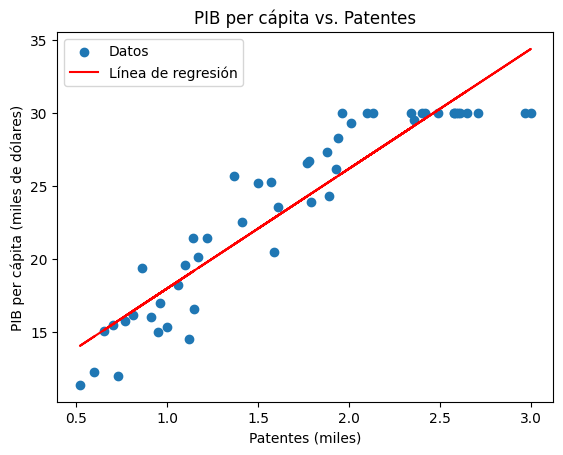

In [123]:
# Visualizar regresión  
plt.scatter(data['Patentes'], data['PIB_per_capita'], label="Datos") 
plt.plot(data['Patentes'], model.predict(X), color='red', label="Línea de regresión") 
plt.title("PIB per cápita vs. Patentes")  
plt.xlabel("Patentes (miles)")  
plt.ylabel("PIB per cápita (miles de dólares)")  
plt.legend() 
plt.show() 

##### Paso 2: Modelo ARIMA para predicción 

In [124]:
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.stattools import adfuller 

# Configurar datos como serie temporal 
data['Año'] = pd.to_datetime(data['Año'], format='%Y') 
data.set_index('Año', inplace=True) 

# Especificar frecuencia anual explícitamente (AS = Annual Start)
data = data.asfreq('YS')  # 'YS' es equivalente a 'AS' (Año que comienza en Enero)
serie = data['PIB_per_capita'] 

# Verificar estacionariedad (prueba de Dickey-Fuller) 
result = adfuller(serie) 
print(f"\nPrueba de Dickey-Fuller para estacionariedad:") 
print(f"Valor p: {result[1]:.4f}") 

if result[1] > 0.05: 
    print("No se rechaza la hipótesis nula: la serie no es estacionaria.") 
else: 
    print("Se rechaza la hipótesis nula: la serie es estacionaria.") 



Prueba de Dickey-Fuller para estacionariedad:
Valor p: 0.3587
No se rechaza la hipótesis nula: la serie no es estacionaria.


In [125]:
# Ajustar modelo ARIMA(1,1,1) 
model_arima = ARIMA(serie, order=(1, 1, 1)).fit() 
print("\nResultados del modelo ARIMA:") 
print(model_arima.summary()) 

# Predecir los próximos 3 años 
forecast = model_arima.forecast(steps=3) 
print(f"\nPronósticos para 2025-2027:\n{forecast}") 


Resultados del modelo ARIMA:
                               SARIMAX Results                                
Dep. Variable:         PIB_per_capita   No. Observations:                   50
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -95.844
Date:                Fri, 23 May 2025   AIC                            197.687
Time:                        18:54:22   BIC                            203.363
Sample:                    01-01-1975   HQIC                           199.841
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1825      0.361     -0.505      0.613      -0.890       0.525
ma.L1         -0.2690      0.413     -0.651      0.515      -1.079       0.541
sigma2         2.9152 

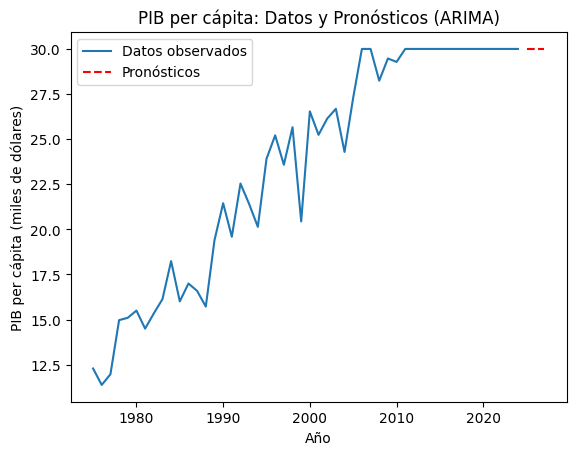

In [126]:
# Visualizar datos y predicciones 
plt.plot(serie, label="Datos observados") 
plt.plot(forecast.index, forecast, 'r--', label="Pronósticos") 
plt.title("PIB per cápita: Datos y Pronósticos (ARIMA)") 
plt.xlabel("Año") 
plt.ylabel("PIB per cápita (miles de dólares)") 
plt.legend() 
plt.show() 

#### Paso 3: Simulación de Monte Carlo para incertidumbre 

In [ ]:
import numpy as np 

# Parámetros de la simulación 

mu = 0.03 # Tasa de crecimiento anual esperada (log-retorno)  

sigma = 0.05 # Volatilidad anual  

n_simulaciones = 10000  

n_años = 3  

pib_inicial = 30 # PIB per cápita en 2024 (miles de dólares) 

 

# Simular log-retornos anuales  

np.random.seed(42)  

log_retornos = np.random.normal(mu, sigma, (n_simulaciones, n_años))  

pib_final = pib_inicial * np.exp(np.sum(log_retornos, axis=1)) 

# Calcular intervalo de confianza del 90%  

pib_lower = np.percentile(pib_final, 5)  

pib_upper = np.percentile(pib_final, 95)  

print(f"\nSimulación de Monte Carlo:")  

print(f"Intervalo de confianza del 90% para el PIB per cápita en 2027: [{pib_lower:.2f}, {pib_upper:.2f}] mil dólares") 

 

# Visualizar distribución de PIB simulado  

plt.hist(pib_final, bins=50, density=True, alpha=0.6, label="PIB simulado") plt.axvline(pib_lower, color='red', linestyle='--', label='Percentil 5%') plt.axvline(pib_upper, color='red', linestyle='--', label='Percentil 95%') plt.title("Distribución del PIB per cápita en 2027 (Monte Carlo)")  

plt.xlabel("PIB per cápita (miles de dólares)")  

plt.ylabel("Densidad")  

plt.legend()  

plt.show() 